Importing libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np
from sklearn import preprocessing
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

The data is read from the disk. The API "kaggle datasets download -d kemical/kickstarter-projects" may also be used. The "encoding" in the command helps us open the csv file without any problems.

In [2]:
df = pd.read_csv('ks-projects-201801.csv', encoding = "ISO-8859-1")

I am converting the different values seen in the states column to numeric values such that it is either 1- meaning that the project has been successful; or 0- the project has failed/has been canceled, and removing the values that may confuse the classifiers among the available states:

In [3]:
df.drop(df[df.state == 'undefined'].index,inplace=True)
df.drop(df[df.state == 'live'].index,inplace=True)
df.drop(df[df.state == 'suspended'].index,inplace=True)
df['state'] = df['state'].map({'failed' : 0,'canceled' : 0,'successful' : 1})

Now, to take a look at what the states most depend on (or how the much the values of the state correlate with the various values in the other categories:

In [4]:
correlation = df.corrwith(df.state, axis=0, drop=False)
correlation

ID                 -0.000891
goal               -0.024968
pledged             0.112105
state               1.000000
backers             0.129141
usd pledged         0.098139
usd_pledged_real    0.111032
usd_goal_real      -0.023709
dtype: float64

We now try to take a look at how much percentage of success each country sees

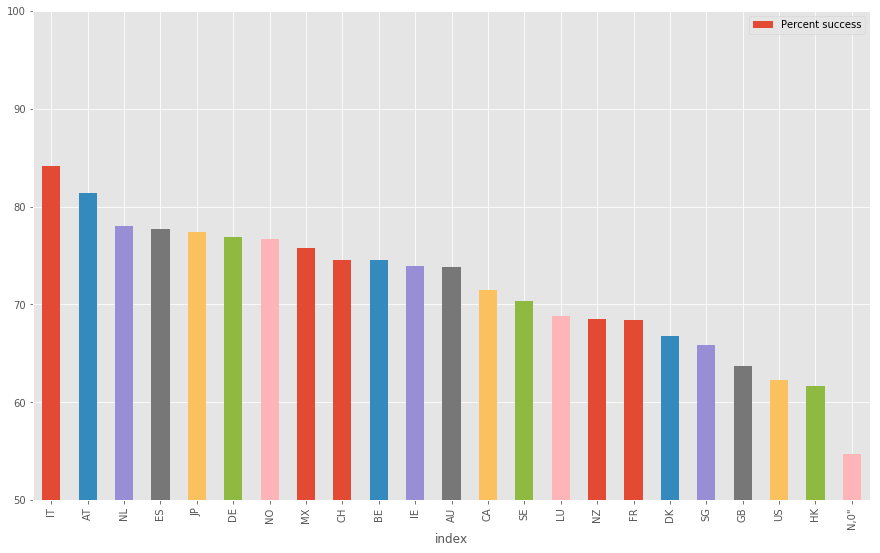

In [5]:
successful_countries = df[df['state'] == 1]
successful_countries = successful_countries["country"].value_counts().to_frame()

df_country=df.country.value_counts().to_frame()
perc_succ = pd.merge(df_country, successful_countries, left_index=True, right_index=True)
perc_succ['Percent success'] = ((perc_succ['country_x'] - perc_succ['country_y'])/perc_succ['country_x'])*100
perc_succ.sort_values(['Percent success'],ascending=False,inplace=True)
perc_succ.reset_index().plot(x='index', y='Percent success',kind="bar",ylim = (50,100),figsize=(15,9))

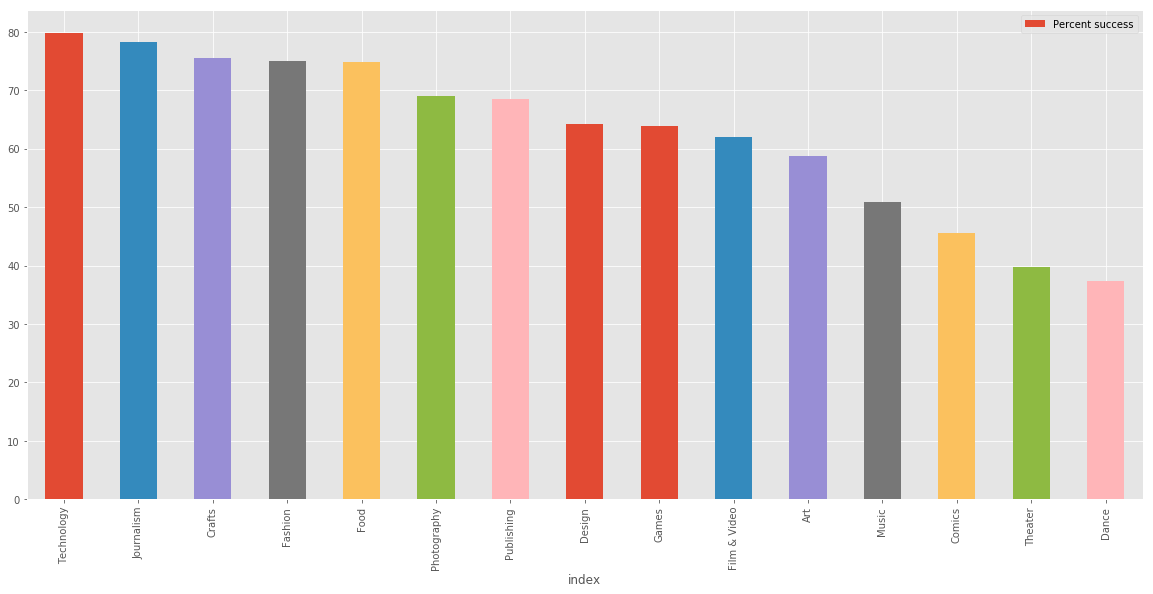

In [6]:
successful_categories = df[df['state'] == 1]
successful_categories = successful_categories["main_category"].value_counts().to_frame()

df_categories=df.main_category.value_counts().to_frame()
perc_succ = pd.merge(df_categories, successful_categories, left_index=True, right_index=True)
perc_succ['Percent success'] = ((perc_succ['main_category_x'] - perc_succ['main_category_y'])/perc_succ['main_category_x'])*100
perc_succ.sort_values(['Percent success'],ascending=False,inplace=True)
perc_succ.reset_index().plot(x='index', y='Percent success',kind="bar",figsize=(20,9))

In [7]:
print("The given table has the following attributes" + str(list(df)))
# Make sure that all the date times are in the proper format in pandas
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])

# # to unix timestamp
df['deadline']=df['deadline'].astype(np.int64)
df['launched']=df['launched'].astype(np.int64)
df['duration']=df['launched']-df['deadline']

The given table has the following attributes['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']


Drop the columns that have values giving away the answer you are setting out to predict, or the values that do not give any necessary addage to the model.

In [8]:
df.drop('ID', axis=1,inplace=True)
df.drop('pledged', axis=1,inplace=True)
df.drop('usd pledged', axis=1,inplace=True)
df.drop('goal', axis=1,inplace=True)
df.drop('usd_pledged_real', axis=1,inplace=True)
df.drop('name', axis=1,inplace=True)
df.drop('deadline', axis=1,inplace=True)
df.drop('launched', axis=1,inplace=True)
df.drop('duration', axis=1,inplace=True)

print("The final model will use the following attributes:" + str(list(df)))

print("The given data has the following unique states:" + str(df.state.unique()))
print("Since the states like 'undefined' and 'suspended' and 'cancelled' provide no value to the classification, we shall remove them.")

The final model will use the following attributes:['category', 'main_category', 'currency', 'state', 'backers', 'country', 'usd_goal_real']
The given data has the following unique states:[0 1]
Since the states like 'undefined' and 'suspended' and 'cancelled' provide no value to the classification, we shall remove them.


Converting non-numeric values to numeric ones. We are using the label encoder to achieve this effect. Label encoder labels the non-numeric values with value between 0 and n_classes-1.

In [9]:
le=preprocessing.LabelEncoder()
le.fit(df.category)
df.category=le.transform(df.category) 
# to see the corresponding names from the numeric values AFTER the transformation, one can use:
# list(le.inverse_transform(list(df.category.unique())))

le.fit(df.main_category)
df.main_category=le.transform(df.main_category) 

le.fit(df.currency)
df.currency=le.transform(df.currency)

le.fit(df.country)
df.country=le.transform(df.country)

As I am have a rather slow computer, I am first trying to test the classification pipeline on a small set of values before trying the whole set of values. In the case below, I am useing only the first 10000 values.

In [10]:
df_new=df[:10000]

Here, 'X' represents the set of features and their corresponding values for each project. 'y' is state which tells us whether the project will be a success or failure. We are using the classifier to predict 'y'

In [11]:
y = df_new.state
X = df_new.drop('state', axis=1)

Now, we first randomize the data (or pseudo-randomize!) and try to split the data into training and test sets. The training set will be the data that shall be used to do the fitting. The test set will be used to test if the model is as good as want it to be ;).

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=102)
 
# Then, we write down the data preprocessing steps. The classifier used in this case is the random forest classifier.
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                          RandomForestClassifier(n_estimators=10))
 
# Now we go on to determine the hyperparameters to tune. These are a set of values that you give in so that we can optimize
# the code.
hyperparameters = { 'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1]}
 
# Tune model using cross-validation pipeline. The grid search is very useful in the optimization of the hyper parameters. Other
# methods to fine-tune the hyper parameters such as the Bayesian optimization exist for random forests. I shall try them if I 
# get a chance!
clf = GridSearchCV(pipeline, hyperparameters, cv=10)

# Let the fitting begin! 
clf.fit(X_train, y_train)

# Evaluate model pipeline on test data.
y_pred = clf.predict(X_test)

#Understand the accueracy of the data
randforest_accu = metrics.accuracy_score(y_test,y_pred)

To get the feature that the model most depends on, we can try to understand the plot given below. According to this, the number of backers are the determining feature on which the classification heavily depends. Next, the classification depends on the currency, and thhen on the country. It depends least on the goal amount.

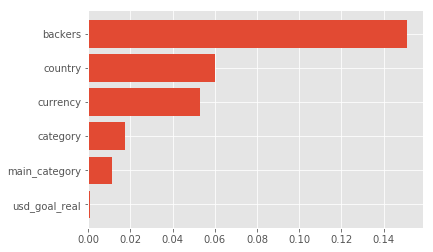

In [13]:
rfc=RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)
def f_importances(coef, names):
    imp = abs(coef[0])
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = list(X)
rfc = LinearSVC()
rfc.fit(X_test,y_test)
f_importances(rfc.coef_, features_names)
y_pred=rfc.predict(X_test)

In [14]:
# Null accuracy for the given data set:
max(y_test.mean(),1-y_test.mean())

0.639

I have used R-squared score (r2) to find how good my model is. The r2 score measures how close the data is to the fitted regression line. A value of 0 indicates that the model explains none of the variability of the response data around its mean.

In [15]:
r2_random_forest = r2_score(y_test, y_pred)
mse_random_forest = mean_squared_error(y_test, y_pred)

#r2 score is around 70%
print(r2_random_forest)
print(mse_random_forest)

0.609847450353088
0.09


This plot shows the population of points lying at the correct locations, and the poplulation of points in the incrrect locations. The purple populations represent the smaller and incorrect values predicted by the model, and the red and yellow regions represent the more correct preditions.

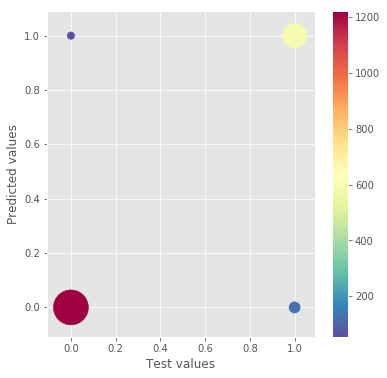

In [16]:
points=list(set(zip(y_test.tolist(),y_pred))) 
count=[len([x for x,y in zip(y_test.tolist(),y_pred) if x==p[0] and y==p[1]]) for p in points]
plot_x=[i[0] for i in points]
plot_y=[i[1] for i in points]
count=np.array(count)
plt.figure(figsize=(6,6))
plt.scatter(plot_x,plot_y,c=count,s=count,cmap='Spectral_r')
plt.xlabel("Test values")
plt.ylabel("Predicted values")
plt.colorbar()
plt.show()

I have used the support vector machine classifier in the linear mode to find the importance of each feature in the data considered. In this case, we learn that  is the most important feature. This importance is calculated using the weights given in the linear svc model

In [17]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
y_pred = linear_svc.predict(X_test)
linear_svc_accu = metrics.accuracy_score(y_test,y_pred)
print(linear_svc_accu)
# Null accuracy
# max(y_test.mean(),1-y_test.mean())
# print(r2_score(y_test, y_pred))
# print(mean_squared_error(y_test, y_pred))

0.8505


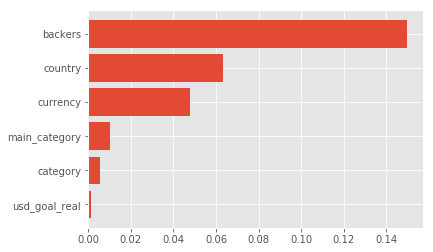

In [18]:
def f_importances(coef, names):
    imp = abs(coef[0])
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = list(X)
svm = LinearSVC()
svm.fit(X_test,y_test)
f_importances(svm.coef_, features_names)
y_pred=svm.predict(X_test)

In [19]:
#Learning feature importance of linear SVM kernel, because non-linear is not possible. And since the SVC is giving an accuracy 
#of 100%, which seems absurd. 
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
svc_accu = metrics.accuracy_score(y_test,y_pred)
print(svc_accu)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_accu = metrics.accuracy_score(y_test,y_pred)
print(logreg_accu)

0.6635
0.9025


In [20]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_accu = metrics.accuracy_score(y_test,y_pred)
print(knn_accu)

0.8805


In [21]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
gnv_accu = metrics.accuracy_score(y_test,y_pred)
print(gnv_accu)

0.7555


In [22]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
dtree_accu = metrics.accuracy_score(y_test,y_pred)
print(dtree_accu)

0.894


In [23]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
sgd_accu = metrics.accuracy_score(y_test,y_pred)
print(sgd_accu)

0.6965


C:\Users\C5269612\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


From the table below, we can see that the accuracy for random forest is the highest.

In [24]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Stochastic Gradient Decent', 
              'Linear SVC', 'Decision Tree'],
    'Score': [svc_accu,knn_accu, logreg_accu,
              randforest_accu, gnv_accu, sgd_accu, 
              linear_svc_accu, dtree_accu]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,0.9230
2,Logistic Regression,0.9025
7,Decision Tree,0.8940
1,KNN,0.8805
6,Linear SVC,0.8505
4,Naive Bayes,0.7555
5,Stochastic Gradient Decent,0.6965
0,Support Vector Machines,0.6635
